In [ ]:
!pip install --quiet langchain langchain_openai langchain_core langchain_experimental
!pip install --quiet langgraph pydantic

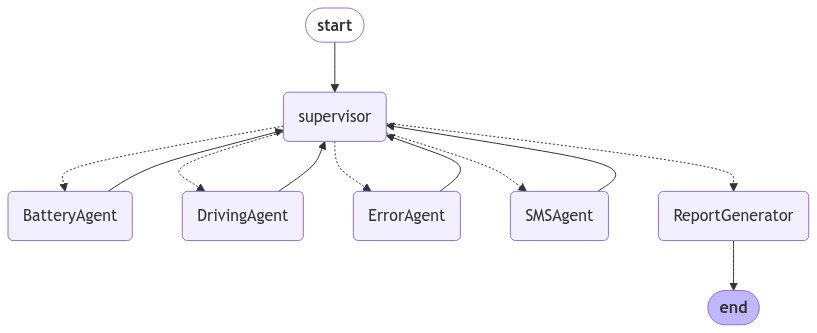

{'supervisor': {'next': 'BatteryAgent'}}
Fetching robot charge statuses...
Sending robot robot_1 to charging station...
{'BatteryAgent': {'messages': [HumanMessage(content="정지 상태의 로봇을 충전소로 보냈습니다. 에러가 발생한 로봇들의 목록을 정리해서 SMS로 보내는 작업은 '확인 필요'합니다.", name='BatteryAgent')]}}
{'supervisor': {'next': 'ErrorAgent'}}
Fetching robot error statuses...
{'ErrorAgent': {'messages': [HumanMessage(content="에러가 발생한 로봇들 목록은 다음과 같습니다:\n1. 로봇 ID: robot_3, 에러: 배터리 고장\n\nSMS로 보내는 작업은 '확인 필요'합니다.", name='ErrorAgent')]}}
{'supervisor': {'next': 'SMSAgent'}}
Sending SMS: 에러가 발생한 로봇들 목록:
1. 로봇 ID: robot_3, 에러: 배터리 고장
{'SMSAgent': {'messages': [HumanMessage(content='에러가 발생한 로봇들의 목록을 SMS로 전송했습니다.', name='SMSAgent')]}}
{'supervisor': {'next': 'ReportGenerator'}}
Generating markdown report: {'title': '로봇 상태 보고서', 'sections': [{'title': '충전소로 보낸 로봇', 'content': '정지 상태의 로봇을 충전소로 보냈습니다.'}, {'title': '에러 발생 로봇 목록', 'content': '1. 로봇 ID: robot_3, 에러: 배터리 고장'}]}
{'ReportGenerator': {'messages': [HumanMessage(content='# 로봇 

In [35]:
import functools
import operator
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)

from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode, create_react_agent

from typing import TypedDict, List, Annotated, Literal

from pydantic import BaseModel
from google.colab import userdata
from IPython.display import Image, display

import operator

# LLM 초기화
llm = ChatOpenAI(openai_api_key=userdata.get('OPENAI_API_KEY'), model="gpt-4o")


def agent_node(state, agent, name):
    result = agent.invoke(state)

#    print(f"Agent {name} returned: {result}")
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)]}

members = ["BatteryAgent", "DrivingAgent", "ErrorAgent", "SMSAgent"]
options = ["ReportGenerator"] + members

class routeResponse(BaseModel):
    next: Literal["BatteryAgent", "DrivingAgent", "ErrorAgent", "SMSAgent", "ReportGenerator"]


def supervisor_agent(state):
    system_prompt = (
      "당신은 아래에 나열된 작업자들 간의 대화를 관리하는 감독관입니다: {members}."
      " 주어진 사용자 요청에 따라, 다음으로 작업할 작업자를 지시하세요."
      " 각 작업자는 할당된 작업을 수행하고 그 결과와 상태를 보고합니다."
      " 모든 작업이 완료되면 'ReportGenerator'를 호출하세요."
    )
    prompt = ChatPromptTemplate.from_messages(
      [
          ("system", system_prompt),
          MessagesPlaceholder(variable_name="messages"),
          (
              "system",
              "위 응답 내용을 참고하여, 다음에 작업할 작업자를 선택하거나,"
              " 작업이 끝났으면 'ReportGenerator'를 호출하세요. 선택할 작업자 중 하나: {options}",
          ),
      ]
    ).partial(options=str(options), members=", ".join(members))

    supervisor_chain = (
        prompt
        | llm.with_structured_output(routeResponse)
    )
    return supervisor_chain.invoke(state)

def report_generator(llm, state):
  system_prompt = (
      "당신은 다른 AI들의 업무 실행 결과를 보고 사용자에게 적절한 응답을 생성해주는 AI 비서입니다."
      "AI 의 업무 실행결과를 확인하고 사용자에게 전달할 내용을 보고서 형태로 정리하세요."
  )
  prompt = ChatPromptTemplate.from_messages(
      [
          ("system", system_prompt),
          ("user", "{result}"),
      ]
  ).partial(result=state)
  # report_chain = (
  #     prompt
  #     | llm
  # )

  return create_react_agent(llm, state_modifier=prompt)


# 로봇 주행 상태 목록 조회 API
@tool
def search_robot_driving_statuses() -> List[TypedDict]:
    """Fetching robot driving statuses"""
    print("Fetching robot driving statuses...")
    return [{"id": "robot_1", "status": "정지"}, {"id": "robot_2", "status": "주행중"}]

# 로봇 충전 상태 목록 조회 API
@tool
def search_robot_charge_statuses() -> List[TypedDict]:
    """Fetching robot charge statuses"""
    print("Fetching robot charge statuses...")
    return [{"id": "robot_1", "battery": 15}, {"id": "robot_2", "battery": 50}]

# 로봇 에러 상태 목록 조회 API
@tool
def search_robot_error_statuses() -> List[TypedDict]:
    """Fetching robot error statuses"""
    print("Fetching robot error statuses...")
    return [{"id": "robot_3", "error": "battery failure"}]

# 로봇에게 충전소 이동 명령 전송 API
@tool
def send_robot_to_charging_station(robot_id) -> str:
    """Sending robot to charging station"""
    print(f"Sending robot {robot_id} to charging station...")
    return f"Robot {robot_id} sent to charging station"

# SMS 알림 전송 API
@tool
def send_sms(message) -> str:
    """Sending SMS report"""
    print(f"Sending SMS: {message}")
    return f"SMS sent with message: {message}"

@tool
def generate_markdown(report) -> str:
    """Generating markdown report"""
    print(f"Generating markdown report: {report}")
    return f"{report}"

# 에이전트 간에 전달되는 상태를 정의
class AgentState(TypedDict):
    # 메시지 목록과 최근 메시지의 발신자를 추적
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str
    result: str


battery_agent = create_react_agent(llm, tools = [search_robot_charge_statuses, send_robot_to_charging_station], state_modifier="""당신은 로봇의 배터리를 관장하는 AI Agent입니다. 질문에 대하여 응답하거나 작업을 수행하세요. 단, 배터리 이외의 내용은 '확인 필요' 응답을 보내야 합니다.""")
driving_agent = create_react_agent(llm, tools = [search_robot_driving_statuses], state_modifier="""당신은 로봇의 주행상태를 관장하는 AI Agent입니다. 질문에 대하여 응답하거나 작업을 수행하세요. 단, 주행상태 이외의 내용은 '확인 필요' 라는 응답을 보내야 합니다.""")
error_agent = create_react_agent(llm, tools = [search_robot_error_statuses], state_modifier="""당신은 로봇의 에러 상태를 관장하는 AI Agent입니다. 질문에 대하여 응답하거나 작업을 수행하세요. 단, 에러상태 이외의 내용은 '확인 필요' 라는 응답을 보내야 합니다.""")
sms_agent = create_react_agent(llm, tools = [send_sms], state_modifier="""당신은 SMS 발송을 담당하는 AI Agent입니다. 질문에 대하여 응답하거나 작업을 수행하세요. 단, 당신이 활용할 수 있는 tool로 해결할 수 없는 질문일 경우 '확인 필요' 라는 응답을 보내야 합니다.""")
report_generator = create_react_agent(llm, tools=[generate_markdown], state_modifier="""당신은 다른 AI들의 업무 실행 결과를 보고 사용자에게 적절한 응답을 생성해주는 AI 비서입니다. 주어진 대화내용을 바탕으로 Markdown 보고서를 만들어주세요.""")

battery_node = functools.partial(agent_node, agent=battery_agent, name="BatteryAgent")
driving_node = functools.partial(agent_node, agent=driving_agent, name="DrivingAgent")
error_node = functools.partial(agent_node, agent=error_agent, name="ErrorAgent")
sms_node = functools.partial(agent_node, agent=sms_agent, name="SMSAgent")
report_generator_node = functools.partial(agent_node, agent=report_generator, name="ReportGenerator")


workflow = StateGraph(AgentState)
workflow.add_node("BatteryAgent", battery_node)
workflow.add_node("DrivingAgent", driving_node)
workflow.add_node("ErrorAgent", error_node)
workflow.add_node("SMSAgent", sms_node)

workflow.add_node("supervisor", supervisor_agent)
workflow.add_node("ReportGenerator", report_generator_node)


for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")

conditional_map = {k: k for k in options}
#conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)

workflow.add_edge("ReportGenerator", END)


workflow.add_edge(START, "supervisor")
# # 그래프 컴파일 및 실행
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

events = graph.stream({"messages": [HumanMessage(content="정지상태의 로봇이 있으면 충전소로 보내주고, 에러발생한 로봇들 목록 정리해서 SMS로 보내줘.")]})
for event in events:
    print(event)